In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.svm import SVC
from sklearn import metrics

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier as RF

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, precision_score, recall_score


In [2]:
# data = pd.read_excel('excel/result/2/k-means_铅钡.xlsx') # SPSSPRO
data = pd.read_excel('excel/result/2/k-means_高钾_oversample.xlsx')
data.head()

,Unnamed: 0,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),量化风化,聚类类别
0,0,92.63,0.033598,0.042751,1.07,0.006069,1.98,0.17,3.24,0.094143,0.067232,0.610000,0.001306,0.007037,0.047864,2,2
1,1,95.02,0.020206,0.590000,0.62,0.005404,1.32,0.32,1.55,0.080138,0.073653,0.350000,0.001554,0.005506,0.043539,2,2
2,2,96.77,0.015791,0.920000,0.21,0.003872,0.81,0.26,0.84,0.071839,0.057292,0.001724,0.001368,0.003911,0.034204,2,2
3,3,94.29,0.038818,1.010000,0.72,0.010529,1.46,0.29,1.65,0.161503,0.118610,0.150000,0.003337,0.011114,0.086089,2,2
4,4,92.35,0.000000,0.740000,1.66,0.640000,3.50,0.35,0.55,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000,2,2


In [3]:
x = data.loc[:,'二氧化硅(SiO2)':'量化风化']
y = data.loc[:,'聚类类别']
print(x.shape)
print(y.shape)

(28, 15)
(28,)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=20,
                                                    shuffle=True)

tranfer = StandardScaler()
x = tranfer.fit_transform(x)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)
print(x.shape)
print(x_train.shape)
print(x_test.shape)

(28, 15)
(22, 15)
(6, 15)


In [5]:
clf = MLPClassifier(
    activation='relu',
    random_state=10,
    solver='adam',
    learning_rate_init=0.01,
    alpha=0.1,
    max_iter=400,
    hidden_layer_sizes=(10, ),
    shuffle=True,
) 

# BP神经网络回归模型
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
print('y_predict', y_predict)

tem_1 = [
    metrics.accuracy_score(y, clf.predict(x)),
    metrics.accuracy_score(y_train, clf.predict(x_train)),
    metrics.accuracy_score(y_test, y_predict),
    precision_score(y_test, y_predict, average='micro'),
    recall_score(y_test, y_predict, average='micro'),
    metrics.f1_score(y_test, y_predict, average='micro'),
]

data2 = pd.DataFrame(data=tem_1,
                     index=[
                         'total_Accuracy', 'train_Accuracy', 'test_Accuracy',
                         'Precision', 'Recall', 'f1'
                     ]).T
data2
# L1=np.abs(y_test-y_predict).mean()  # 模型评价
# print(L1)
# print(precision_score(y_test, y_predict))

y_predict [1 2 2 1 3 3]


,total_Accuracy,train_Accuracy,test_Accuracy,Precision,Recall,f1
0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
bounds_list = []

for i in range(x.shape[1]):
    # 这个地方应该是这样的，比赛的时候写错了 a = [x[:, i].min(),x[:,i].max()]
    a = [x[:, i].min(), x[:, 0].max()]
    bounds_list.append(a)
print(len(bounds_list))

15


In [7]:
problem = {
    'num_vars':
    x.shape[1],
    'names': [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
        'x12', 'x13', 'x14', 'x15'
    ],
    'bounds':
    bounds_list
}
param_values = saltelli.sample(problem, 1000)

param_values.shape

c:\Miniconda\envs\math\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


(32000, 15)

In [8]:
Y = np.zeros([param_values.shape[0]])
for i in range(param_values.shape[0]):
    a=clf.predict(param_values[i].reshape(1,-1))
    Y[i] = a
Y = Ishigami.evaluate(param_values)
Y

array([-0.70461373,  1.20569928,  5.77630602, ...,  2.46699962,
        2.46699962,  2.46699962])

In [9]:
Si = sobol.analyze(problem, Y, print_to_console=True)
Si

           ST   ST_conf
x1   0.097201  0.007993
x2   0.894909  0.060532
x3   0.005087  0.000761
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
           S1   S1_conf
x1   0.095000  0.025612
x2   0.895515  0.075691
x3   0.000778  0.006436
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
                  S2   S2_conf
(x1, x2)   -0.006480  0.048933
(x1, x3)    0.001074  0.037446
(x1, x4)   -0.003183  0.037098
(x1, x5)   -0.003183  0.037098
(x1, x6)   -0.003183  0.037098
...              ...       ...
(x12, x14)  0.0

{'S1': array([9.49998946e-02, 8.95514661e-01, 7.78008465e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'S1_conf': array([0.02561205, 0.07569057, 0.00643614, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'ST': array([0.09720064, 0.89490881, 0.00508688, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'ST_conf': array([0.00799328, 0.06053175, 0.00076059, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'S2': array([[        nan, -0.00648023,  0.00107371, -0.00318331, -0.0031

In [10]:
Si_data = {
    'S1': Si['S1'],
    'S1_conf': Si['S1_conf'],
    'ST': Si['ST'],
    'ST_conf': Si['ST_conf'],
}
data_Si =pd.DataFrame(Si_data)
data_Si.to_excel('./excel/result/2/analysis.xlsx')
data_Si.head()

,S1,S1_conf,ST,ST_conf
0,0.095000,0.025612,0.097201,0.007993
1,0.895515,0.075691,0.894909,0.060532
2,0.000778,0.006436,0.005087,0.000761
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000


In [11]:
print("x1-x2:", Si['S2'][0, 1])
print("x1-x3:", Si['S2'][0, 2])
print("x2-x3:", Si['S2'][1, 2])

x1-x2: -0.006480232647261386
x1-x3: 0.0010737091488327733
x2-x3: 0.0020852247605257102


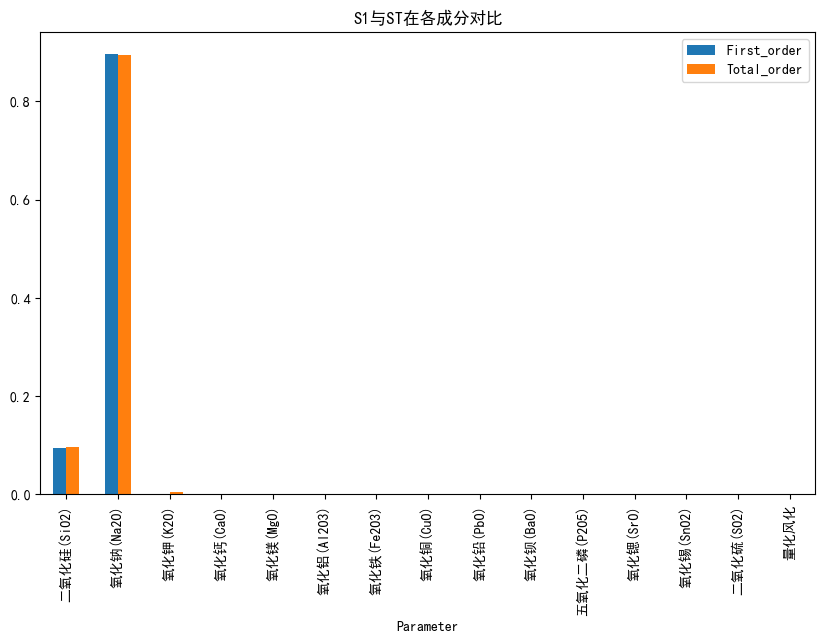

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]  #设置字体
plt.rcParams["axes.unicode_minus"] = False  #该语句解决图像中的“-”负号的乱码问题

df_sensitivity = pd.DataFrame({
    "Parameter":
    data.loc[:, '二氧化硅(SiO2)':'量化风化'].columns,
    "First_order":
    Si["S1"],
    "Total_order":
    Si["ST"]
}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10, 6))
df_sensitivity.plot(kind="bar", ax=axes)
plt.title('S1与ST在各成分对比')
# plt.figure(figsize=(30,30))
# plt.savefig('./excel/result/2/S1.png')
plt.show()


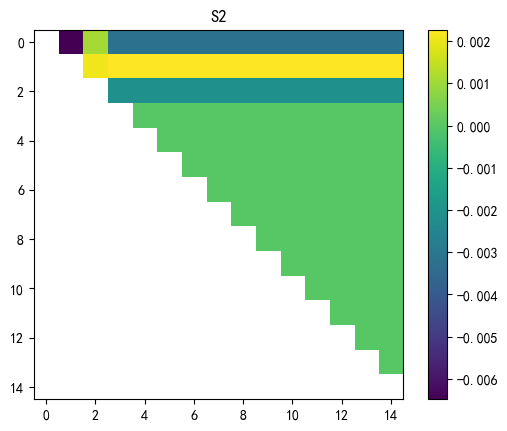

In [13]:
from matplotlib import pyplot as plt

X=Si['S2']
plt.imshow(X)
plt.colorbar()
plt.title('S2')
plt.savefig('./excel/result/2/S2_heatmap.png')
plt.show()

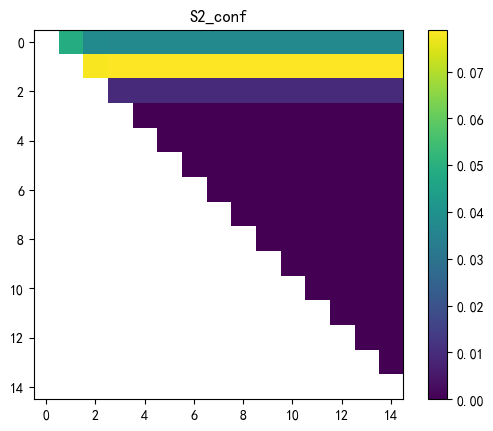

In [14]:
X = Si['S2_conf']
plt.imshow(X)
plt.colorbar()
plt.title('S2_conf')
plt.savefig('./excel/result/2/S2_conf_heatmap.png')
plt.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

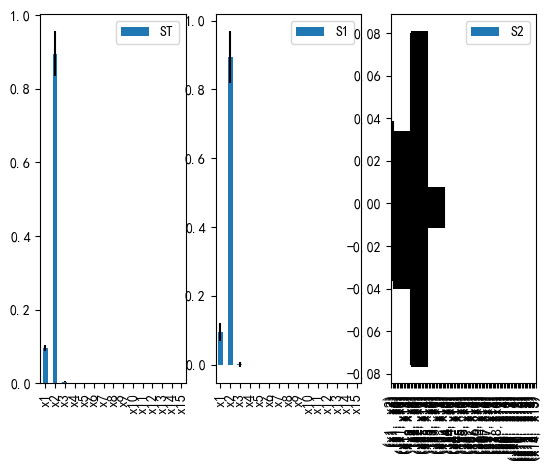

In [15]:
Si.plot()

S1: [9.49998946e-02 8.95514661e-01 7.78008465e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
x1-x2: -0.006480232647261386
x1-x3: 0.0010737091488327733
x2-x3: 0.0020852247605257102


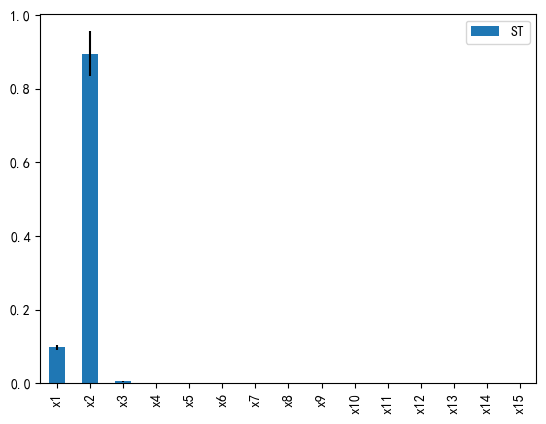

In [16]:
# 一阶灵敏度
print('S1:', Si['S1']) 

# 二阶林敏度
print("x1-x2:", Si['S2'][0, 1])
print("x1-x3:", Si['S2'][0, 2])
print("x2-x3:", Si['S2'][1, 2])

"""
    置信区间: 对这个样本的某个总体参数的区间估计，置信区间展现的是这个参数的真实值有一定概率落在测量结果的周围的程度。
             置信区间给出的是被测量参数的测量值的可信程度。一般常取为95%或者90%或者99%.是预先取定的值.
             如:如果在一次大选中某人的支持率为55%，而置信水平0.95上的置信区间是（50%,60%），那么他的真实支持率有百分之九十五的机率落在百分之五十和百分之六十之间
    显著性水平: 一个预先取定的值（一般取0.05/0.01）,一般用alpha表示.跟置信概率恰好方向相反（加起来是1）,在假设检验中表示在零假设成立下拒绝它所犯的一类错误的上界.在用p值检验时,
              如果p值比显著性水平小,就可以放心拒绝原假设.反之,不拒绝.
    置信度: 置信区间上下限的差值。
"""
from SALib.plotting.bar import plot as barplot
import matplotlib.pyplot as plot

Si_df = Si.to_df()
barplot(Si_df[0])
plot.savefig('./excel/result/2/analysis_x.png')
plot.show()